## Ranking Algorithms for Midwest Machine Learning Symposim 2017 Poster Contest
### Authors: Amanda Bower, Lalit Jain, Laura Balzano
In this notebook (using Python 2), we implement three rank aggregation algorithms for the MMLS poster competition. We will use the Borda, Bradley-Terry-Luce, and Kemeny aggregation methods. For more details about the rank aggregation algorithms and a summary of the results of the poster contest, see [Report on Rank Aggregation Methods for MMLS 2017.](https://github.com/Amandarg/MMLS2017PosterJudging/blob/master/Rank%20Aggregation%20for%20MMLS.pdf)

For the Kemeny aggregation, we provide brute force code, an implementation using ``lpsolve``, and an implementation using ``cvxopt/.glpk``. 

For installation instructions for ``lpsolve`` for Python see [Using lpsolve from Python](http://lpsolve.sourceforge.net/5.5/Python.htm) and to download the ``lpsolve`` files referenced in the instructions, [click here.](https://sourceforge.net/projects/lpsolve/files/lpsolve/5.5.0.15/)

If you have trouble installing ``lpsolve``, our code can also use the integer linear program solver in ``cvxopt/.glpk``. For installation instructions, see [Linear Programming in Python with CVXOPT.](https://scaron.info/blog/linear-programming-in-python-with-cvxopt.html) Note that both ``CVXOPT`` and ``GLPK`` must be installed.

Throughout our code, a partial ranking denotes a list of the form ``[a,b,c,...]`` which indicates that item `a` is better than item `b`, item `b` is better than item `c` etc. 

In [1]:
import random
from collections import defaultdict
from itertools import combinations, permutations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# UTILITY FUNCTIONS

def build_N(rankings, n):
    '''
    Builds a nxn matrix from a set of rankings where the i-jth entry is the number of times i beats j
    rankings: a list of (partial) rankings
    n: number of items
    
    returns:
    N: nxn matrix whose (i,j)th entry is # times i beat j
    '''
    N = np.zeros((n,n))
    for r in rankings:
        for i in range(len(r)):
            for j in range(i+1, len(r)):
                N[r[i],r[j]] += 1
    return N

def kendalltau_dist(rank, partial):
    '''
    Computes the Kendall tau distance between a FULL ranking (rank) and a PARTIAL ranking (partial). 
    The Kendall-Tau distance in this case is the number of pairs (i,j) where rank ranks i and j in a different
    order from partial. If partial is a full ranking, this is the normal Kendall tau distance.
    '''
    d = 0
    rank_inv = dict(zip(rank, range(len(rank)) ))
    for i in range(len(partial)):
        for j in range(i+1, len(partial)):
            if rank_inv[partial[i]] > rank_inv[partial[j]]:
                d+=1
    return d

### Kemeny Aggregation Code
Kemeny aggregation finds a full ranking that minimizes the average distance to a set of partial rankings. In general
a difficult combinatorial optimization problem, it can be reformulated as an integer linear program in an easy way.

Our code is loosely based on the method here [http://vene.ro/blog/kemeny-young-optimal-rank-aggregation-in-python.html#note3](vene's blog).

In [2]:
def build_objective(N, extend=False):
    '''
    Returns the objective for the linear program.
    '''
    return N.ravel()

def build_constraints(n, solver='lpsolve'):
    '''
    In the lp formulation of Kemeny rank aggregation a nxn 0-1 matrix x is used to encode the permutation. 
    x satisfies: x[i,j] + x[j,i] = 1, and x[i,j]+x[j,k]+x[k,i] >= 1
    
    This method builds these constraints in the appropriate form for lpsolve and glpk.
    '''
    idx = lambda i, j: n * i + j

    #n choose 2 rows by n^2. rows are constraints and columns correspond to variables
    pairwise_constraints = np.zeros(((n * (n - 1)) / 2, n ** 2))
    for row, (i, j) in zip(pairwise_constraints, combinations(range(n), 2)):
        row[[idx(i, j), idx(j, i)]] = 1
    # and for every cycle of length 3
    triangle_constraints = np.zeros(((n * (n - 1) *(n - 2)), n ** 2))
    for row, (i, j, k) in zip(triangle_constraints, permutations(range(n), 3)):
        row[[idx(i, j), idx(j, k), idx(k, i)]] = 1

    if solver=='lpsolve':
        constraints = np.vstack([pairwise_constraints, triangle_constraints])
        constraint_rhs = np.hstack([np.ones(len(pairwise_constraints)),
                                    np.ones(len(triangle_constraints))])
        constraint_signs = np.hstack([np.zeros(len(pairwise_constraints)),
                                      np.ones(len(triangle_constraints))])   # ==
        return constraints, constraint_rhs, constraint_signs
    elif solver=='glpk':
        G = -1*triangle_constraints
        h = -1*np.ones(len(G))
        A = pairwise_constraints
        b = np.ones(len(A))
        return G,h,A,b
    else:
        raise

def kemeny_lpsolve(rankings, n):
    '''
    Kemeny rank aggregation using lpsolve55
    '''
    from lp_solve import lp_solve
    N = build_N(rankings, n)
    c = -1*build_objective(N)
    constraints, constraint_rhs, constraint_signs = build_constraints(n, 'lpsolve')
    obj, x, duals = lp_solve(c, constraints, constraint_rhs, constraint_signs.T)
                             #xint=range(1, 1 + n_candidates ** 2))
    x = np.array(x).reshape((n, n))
    aggr_rank = x.sum(axis=0)
    return obj, np.argsort(aggr_rank)[::-1], x

def kemeny_glpksolve(rankings,n):
    '''
    Kemeny rank aggregation using glpk
    '''
    from cvxopt import matrix
    from cvxopt.glpk import ilp
    N = build_N(rankings, n)
    c = build_objective(N)
    G,h,A,b = build_constraints(n, 'glpk')
    status, x = ilp(c, matrix(G), matrix(h), matrix(A), matrix(b),
                    set(range(n**2)), set(range(n**2)))
    x = np.array(x).reshape((n, n))
    aggr_rank = x.sum(axis=0)
    return None, np.argsort(aggr_rank)[::-1], x

def rankaggr_brute(ranks, n):
    '''
    Kemeny rank aggregation using brute force methods. 
    DO NOT USE FOR n>9!!!
    '''
    min_dist = np.inf
    best_rank = defaultdict(int)
    count =0
    for candidate_rank in permutations(range(n)):
        count +=1
        dist = np.sum(kendalltau_dist(candidate_rank, rank) for rank in ranks)
        if dist <= min_dist:
            min_dist = dist
            best_rank[candidate_rank]=dist
    
    min_dist = min(best_rank.values())
    return [key for key, value in best_rank.iteritems() if value == min_dist]



### Borda Count
Borda count methods assign points to items depending on what rank they have in each ranking and ranks the items by their final points.

In [3]:
def borda_reduction(rankings, n):
    '''
    Basic Borda Reduction method for computing the winner. 
    Computes the pairwise matrix N, and then normalizes the entries by the number of times i was compared to j.
    '''
    N = build_N(rankings, n)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                total = N[i,j]+N[j,i]
                if total == 0:
                    M[i,j] = 0
                else:
                    M[i,j] = N[i,j]*1.0 / total
    return np.argsort(np.sum(M, axis=1))[::-1]

def borda_reduction_score(rankings, n):
    '''
    Basic Borda Reduction method for computing the winner. 
    Assigns n-(i-1) points to item j whenever item j is ranked i in some partial ranking.
    '''
    d = defaultdict(int)
    for r in rankings:
        for i in range(len(r)):
            d[r[i]] += n-i
    return sorted([(x, d[x]) for x in d.keys()], key=lambda x:x[1])[::-1]

### Bradley-Terry-Luce
The Bradley-Terry-Luce (BTL) model is a parametric model on the probability that item `i` beats item `j` and ranks the items based on the probability that an item beats the others. The items are then ranked by the probability that an item beats all the others.

In [4]:
def btl(rankings, n):
    """
    Uses LogisticRegression to compute the BTL scores based on the rankings. 
    """
    from sklearn.linear_model import LogisticRegression
    X,y = get_X_y(rankings, n)
    model = LogisticRegression(fit_intercept=False, verbose=True, C=1000000.)
    # parameter C controls regularization. High C => less regularization
    model = model.fit(X,y)
    return np.argsort(model.coef_.flatten())[::-1]

def get_X_y(rankings,n):
    '''
    Build the X and y matrices for the Logistic regression classifier.
    '''
    num_comparisons = 0
    for r in rankings:
        num_comparisons += len(r)*(len(r)-1)/2
    num_comparisons = num_comparisons
    X = np.zeros((num_comparisons,n))
    y = np.zeros((num_comparisons))
    comparison =0
    for r in rankings:
        for i in range(len(r)-1):
            for j in range(i+1, len(r)):
                lower  = min(r[i], r[j])
                higher = max(r[i], r[j])
                X[comparison, lower]=1
                X[comparison, higher]=-1
                if(lower == r[i]):
                    y[comparison] = 1
                else:
                    y[comparison] = -1
                comparison +=1
    return X, y

# Day 1 Data
Below is the data from the first day of the MMLS poster competition where poster numbers have been randomized along with the code to run Borda as well as basic statistics about the data.

How Many Ballots Received: 39
Average Ballot Length: 5


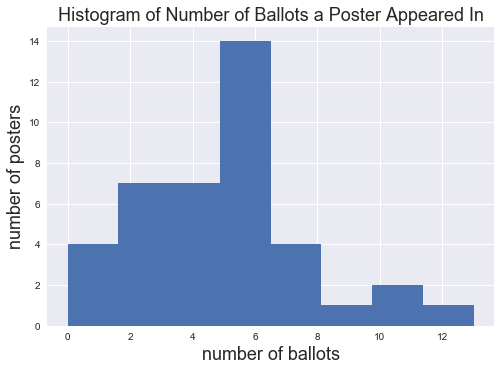

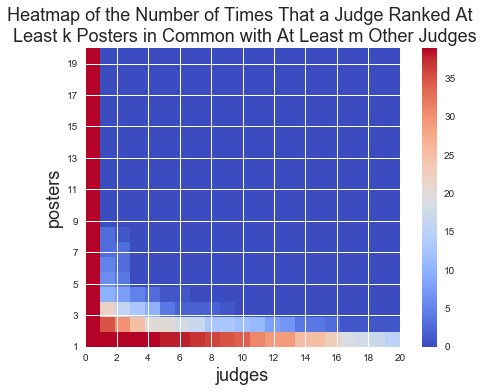

Borda Rank Aggregation: [1, 14, 16, 27, 25, 7, 39, 28, 8, 4, 19, 5, 38, 0, 20, 29, 34, 26, 9, 21, 13, 12, 10, 17, 3, 31, 35, 22, 2, 24, 36, 37, 33, 23, 11, 30, 6, 18, 15]


In [5]:
#randomized poster numbers in {0,1,2, ..., 39}
ranks = [[24, 36],
         [10, 14, 11, 7],
         [25, 39],
         [14, 34, 19, 7],
         [14, 19, 10, 29, 7],
         [9, 6, 8],
         [33, 10, 16],
         [7, 25, 15, 1, 16],
         [0, 22, 35],
         [20, 8],
         [0, 1, 26, 31, 27, 28],
         [0, 26, 18, 7, 28],
         [21, 13, 35, 11],
         [25, 39, 3],
         [30, 27],
         [8, 38, 9, 27, 12, 22, 23, 1, 21, 5],
         [31, 29],
         [4, 5, 21, 14, 34, 22, 17, 37, 31, 12, 2, 11, 13, 0],
         [16, 27, 24, 19],
         [16, 36, 21, 5],
         [29, 20, 34, 3],
         [29, 10, 16],
         [31, 38, 14],
         [14, 16, 22, 19, 2, 4, 28, 39],
         [16, 20, 28, 27, 39, 13, 1],
         [7, 0, 27, 17, 26, 13, 14],
         [24, 2, 20, 8, 33],
         [39, 14, 28],
         [25, 1, 27],
         [1, 4, 34, 25, 16, 36],
         [5, 4, 14, 1, 20, 29, 19, 38, 16, 0],
         [3, 25, 39],
         [1, 8, 35, 38, 27, 23, 2, 33, 12, 21, 9],
         [27, 8, 38, 12, 23, 1, 9, 35],
         [17, 37, 4, 1, 5, 3, 34, 16, 26],
         [14, 25],
         [1, 28, 9, 14, 19, 7],
         [13, 1, 28, 12, 30],
         [17, 4, 5, 37, 1, 26, 39, 38]]

n = 40

print 'How Many Ballots Received:', len(ranks)

length = 0
for r in ranks:
    length += len(r)

print 'Average Ballot Length:', length/len(ranks)

#array of item to number of times it was ranked
rank_array = np.zeros(n)
for r in ranks:
    for i in r:
        rank_array[i] +=1

plt.hist(rank_array, bins='auto')
plt.title('Histogram of Number of Ballots a Poster Appeared In', fontsize=18)
plt.xlabel('number of ballots', fontsize=18)
plt.ylabel('number of posters', fontsize=18)
plt.show()

#dictionary of items to number of times it was ranked
rank_dict = defaultdict(int)
for r in ranks:
    for i in r:
        rank_dict[i] +=1

#computes number of ballots that ranked at least k other items in common with at least m other ballots
def num_k_m(ranks, k, m):
    counts = []
    ranks = [set(a) for a in ranks]
    for a in ranks:
        c = 0
        for b in ranks:
            if a!= b:
                if len(a.intersection(b)) >= k:
                    c += 1
        if c >= m:
            counts.append(1)
        else:
            counts.append(0)
    return sum(counts)

heatmap = np.zeros((20,21))
for k in range(1,21):
    for m in range(21):
        heatmap[k-1,m] = num_k_m(ranks, k, m)

#for heatmap plot
import matplotlib.cm
fig, ax = plt.subplots()
plt.imshow(heatmap, interpolation='none', origin='lower', cmap=matplotlib.cm.coolwarm, extent=[0,20,1,20])
plt.title('Heatmap of the Number of Times That a Judge Ranked At \n Least k Posters in Common with At Least m Other Judges', fontsize=18)
labels_x = [0,2,4,6,8,10,12,14,16,18,20]
labels_y = [1,3,5,7,9,11,13,15,17,19]
plt.xticks(labels_x)
plt.yticks(labels_y)
plt.colorbar()
plt.xlabel('judges', fontsize=18)
plt.ylabel('posters', fontsize=18)
plt.show()

borda_score_aggr = borda_reduction_score(ranks, n)
print 'Borda Rank Aggregation:', [t[0] for t in borda_score_aggr]

## Day 2 Finalist Data
Below is the full ranking data from 8 judges on the 5 finalist posters whose numbers have been randomized along with the code to run Kemeny, Borda, and BTL.

In [6]:
#randomized finalist data
ranks_finalists = [[1, 4, 2, 0, 3],
                   [3, 2, 0, 1, 4],
                   [3, 1, 2, 0, 4],
                   [1, 0, 2, 4, 3],
                   [0, 4, 1, 2, 3],
                   [0, 2, 1, 4, 3],
                   [3, 2, 1, 0, 4],
                   [0, 2, 1, 4, 3]]
n = 5

borda_aggr = borda_reduction(ranks_finalists, n)
borda_score_aggr = borda_reduction_score(ranks_finalists, n)
btl_aggr = btl(ranks_finalists, n)
_, kemeny_aggr, x_lpsolve = kemeny_lpsolve(ranks_finalists, n)
kemeny_brute = rankaggr_brute(ranks_finalists, n)

print '(ignore output above from the ILP solver)'
print '\n', 'RESULTS:'
print 'Borda:', [t for t in borda_aggr]
print 'BTL:', [t for t in btl_aggr]
print 'Kemeny solved as an ILP with lpsolve55:', [t for t in kemeny_aggr]
print 'All Kemeny Solutions Solved with Brute Force:', [[t for t in ranking] for ranking in kemeny_brute]


[LibLinear]m,n 70 25
(ignore output above from the ILP solver)

RESULTS:
Borda: [1, 0, 2, 3, 4]
BTL: [0, 1, 2, 3, 4]
Kemeny solved as an ILP with lpsolve55: [2, 1, 0, 4, 3]
All Kemeny Solutions Solved with Brute Force: [[0, 1, 2, 4, 3], [2, 1, 0, 4, 3], [2, 0, 1, 4, 3], [0, 2, 1, 4, 3], [1, 0, 2, 4, 3], [1, 2, 0, 4, 3]]


lp_solve.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if f == None:
